# Imports etc.

In [1]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
import scipy
gg.theme_set(gg.theme_bw)

In [4]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/'
plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots'
mouse_data_dir = 'C:/Users/maria/MEGAsync/SLCN/PSMouseData'

In [13]:
save_or_load_true_mouse_dat = 'save'  # 'load'

# Load mouse data

In [8]:
n_trials = 725

In [9]:
def replace_nans(data):

    data[np.isnan(data)] = np.random.binomial(1, 0.5, np.sum(np.isnan(data)))
    return data

# Example use
replace_nans(np.full(10, np.nan))

array([1., 1., 0., 1., 0., 1., 0., 0., 0., 0.])

In [14]:
if save_or_load_true_mouse_dat == 'save':
    
    # Load data
    rewards_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_Reward.csv')).T.values[:n_trials]
    rewards_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_Reward.csv')).T.values[:n_trials]
    actions_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_Choice.csv')).T.values[:n_trials]
    actions_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_Choice.csv')).T.values[:n_trials]
    correct_actions_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_TaskData.csv')).T.values[:n_trials]
    correct_actions_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_TaskData.csv')).T.values[:n_trials]
    fullID_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_AnimalID.csv')).T.values.flatten()
    fullID_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_AnimalID.csv')).T.values.flatten()

    # Clean data
    n_trials_per_animal = np.sum(np.invert(np.isnan(rewards_j)), axis=0)
    n_trials = np.round(np.percentile(n_trials_per_animal, 0.8)).astype('int')
    rewards_j = replace_nans(rewards_j).astype('int')
    actions_j = replace_nans(actions_j).astype('int')
    rewards_a = replace_nans(rewards_a).astype('int')
    actions_a = replace_nans(actions_a).astype('int')
    correct_actions_j = replace_nans(correct_actions_j).astype('int')
    correct_actions_a = replace_nans(correct_actions_a).astype('int')

    # Combine juvenile and adult data
    fullIDs = np.concatenate([fullID_j, fullID_a])
    animals = [int(str(fullID)[:-5]) for fullID in fullIDs]
    ages = [int(str(fullID)[-5:-2]) for fullID in fullIDs]
    rewards = np.hstack([rewards_j, rewards_a])  # (n_trials, n_cols)
    actions = np.hstack([actions_j, actions_a])
    correct_actions = np.hstack([correct_actions_j, correct_actions_a])
    corrects = (actions == correct_actions).astype('int')
    rewards[corrects == 0] = 0  # to fix errors of replace_nans
    assert np.shape(rewards) == np.shape(actions)

## Format mouse data

In [125]:
if save_or_load_true_mouse_dat == 'save':
    
    true_dat = pd.DataFrame()
    for i, fullID in enumerate(fullIDs):
        
        # Basic info
        subj_dat = pd.DataFrame({
            'animal': int(str(fullID)[:-5]),
            'age': int(str(fullID)[-5:-2]),
            'action': actions[:, i],
            'reward': rewards[:, i],
            'correct': corrects[:, i],
            'correct_action': correct_actions[:, i],
            'trial': range(len(actions)),
            'block': np.append([0], np.cumsum(np.abs(np.diff(correct_actions[:, i])))),
            'gender': int(str(fullID)[-2:-1]),
            'agegroup': int(str(fullID)[-1:]),
            'fullID': [fullID] * len(actions),
        })

        # Session info
        for age in np.unique(subj_dat.age):
            subj_dat.loc[subj_dat.age == age, 'rew_1ago'] = np.append(np.nan, subj_dat['reward'][:-1])
            subj_dat.loc[subj_dat.age == age, 'rew_2ago'] = np.append(np.nan, subj_dat['rew_1ago'][:-1])
            subj_dat.loc[subj_dat.age == age, 'switch'] = np.append(np.nan, np.abs(np.diff(subj_dat.action)))

            # Block info
            for block in np.unique(subj_dat.block):
                sub_idx = (subj_dat.block == block) * (subj_dat.age == age)
                block_length = sum(sub_idx)

                if block_length > 5:
                    block_trial = range(block_length)
                    trials2switch = np.append(np.arange(block_length-3), np.arange(-3, 0))
                else:
                    block_trial = [np.nan] * block_length
                    trials2switch = [np.nan] * block_length

                subj_dat.loc[sub_idx, 'block_length'] = block_length
                subj_dat.loc[sub_idx, 'block_trial'] = block_trial
                subj_dat.loc[sub_idx, 'trials2switch'] = trials2switch

        true_dat = true_dat.append(subj_dat)

    # Session and gender
    for animal in np.unique(true_dat.animal):
        ani_age = true_dat.loc[true_dat.animal == animal, 'age']
        true_dat.loc[true_dat.animal == animal, 'session'] = ani_age - np.min(ani_age)
    true_dat['gender'] = true_dat['gender'].astype('category')
    true_dat['rew_12ago'] = [str(r1)[0] + str(r2)[0] for r1, r2 in zip(true_dat['rew_1ago'], true_dat['rew_2ago'])]
    
    # Save as csv
    true_dat.to_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


     animal  age  action  reward  correct  correct_action  trial  block  \
0        14   40       0       0        0               1      0      0   
1        14   40       0       0        0               1      1      0   
2        14   40       1       1        1               1      2      0   
3        14   40       1       1        1               1      3      0   
4        14   40       1       1        1               1      4      0   
..      ...  ...     ...     ...      ...             ...    ...    ...   
720      13   90       1       1        1               1    720     30   
721      13   90       1       1        1               1    721     30   
722      13   90       1       1        1               1    722     30   
723      13   90       1       1        1               1    723     30   
724      13   90       1       0        0               0    724     31   

    gender  agegroup   fullID  rew_1ago  rew_2ago  switch  block_length  \
0        1         2  14

In [6]:
if save_or_load_true_mouse_dat == 'load':
    true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'))

,Unnamed: 0,animal,age,action,reward,correct,correct_action,trial,block,gender,agegroup,fullID,block_trial,session
0,0,14,40,0,0,0,1,0,0,1,2,1404012,0.0,0.0
1,1,14,40,0,0,0,1,1,0,1,2,1404012,1.0,0.0
2,2,14,40,1,1,1,1,2,0,1,2,1404012,2.0,0.0
3,3,14,40,1,1,1,1,3,0,1,2,1404012,3.0,0.0
4,4,14,40,1,1,1,1,4,0,1,2,1404012,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319720,720,13,90,1,1,1,1,720,30,2,1,1309021,16.0,18.0
319721,721,13,90,1,1,1,1,721,30,2,1,1309021,17.0,18.0
319722,722,13,90,1,1,1,1,722,30,2,1,1309021,18.0,18.0
319723,723,13,90,1,1,1,1,723,30,2,1,1309021,19.0,18.0


In [130]:
true_dat

(319725, 19)

# Load simulated data

In [138]:
n_agents = 2
modelnames = [f for f in os.listdir(fitted_param_dir) if ('.csv' in f) and ('params' in f)]
model_names = [modelname.split('_')[1] for modelname in modelnames]

In [139]:
model_name = model_names[0]
simulation_dir = os.path.join(fitted_param_dir, 'simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
sim_data = pd.read_csv(simulation_dir)
sim_data

,Unnamed: 0,trial,action,lik,reward,correct,correct_action,mean_reward,mean_correct,block,session,animal,age,model
0,0,0,[1 1],[[1.499995 1.499995]\n [1.499995 1.499995]],[0 1],[1 1],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,0.5,1.0,0,0.0,14,40,RLabcd
1,1,1,[0 1],[[1.75276176 1.24722824]\n [1.04299829 1.95699...,[0 0],[0 1],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,0.0,0.5,0,0.0,14,40,RLabcd
2,2,2,[0 1],[[1.499995 1.499995 ]\n [1.20278904 1.79720...,[0 1],[0 1],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,0.5,0.5,0,0.0,14,40,RLabcd
3,3,3,[1 1],[[1.37912435 1.62086565]\n [1.05532099 1.94466...,[1 1],[1 1],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,1.0,1.0,0,0.0,14,40,RLabcd
4,4,4,[0 1],[[1.0680344 1.9319556 ]\n [1.02976822 1.97022...,[0 1],[0 1],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,0.5,0.5,0,0.0,14,40,RLabcd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151783,258,258,[1 1],[[1.03891 1.96108 ]\n [1.07051349 1.92947...,[1 1],[1 1],[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,1.0,1.0,8,2.0,37,45,RLabcd
151784,259,259,[1 1],[[1.03853966 1.96145034]\n [1.04558485 1.95440...,[1 1],[1 1],[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,1.0,1.0,8,2.0,37,45,RLabcd
151785,260,260,[1 1],[[1.03839192 1.96159808]\n [1.04067095 1.95931...,[0 1],[1 1],[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,0.5,1.0,8,2.0,37,45,RLabcd
151786,261,261,[0 1],[[1.31462193 1.68536807]\n [1.03936184 1.96062...,[0 1],[0 1],[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,0.5,0.5,8,2.0,37,45,RLabcd


In [148]:
# sub_dat = sim_data[:500]
selected_mouse = 0
for col in ['action', 'correct_action', 'reward', 'correct']:
    sub_dat[col+'_{}'.format(selected_mouse)] = sub_dat[col].apply(lambda x: x[selected_mouse+1])

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [149]:
sub_dat

,Unnamed: 0,trial,action,lik,reward,correct,correct_action,mean_reward,mean_correct,block,session,animal,age,model,action_0,correct_action_0,reward_0,correct_0
0,0,0,[1 1],[[1.499995 1.499995]\n [1.499995 1.499995]],[0 1],[1 1],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,0.5,1.0,0,0.0,14,40,RLabcd,1,1,0,1
1,1,1,[0 1],[[1.75276176 1.24722824]\n [1.04299829 1.95699...,[0 0],[0 1],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,0.0,0.5,0,0.0,14,40,RLabcd,0,1,0,0
2,2,2,[0 1],[[1.499995 1.499995 ]\n [1.20278904 1.79720...,[0 1],[0 1],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,0.5,0.5,0,0.0,14,40,RLabcd,0,1,0,0
3,3,3,[1 1],[[1.37912435 1.62086565]\n [1.05532099 1.94466...,[1 1],[1 1],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,1.0,1.0,0,0.0,14,40,RLabcd,1,1,1,1
4,4,4,[0 1],[[1.0680344 1.9319556 ]\n [1.02976822 1.97022...,[0 1],[0 1],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,0.5,0.5,0,0.0,14,40,RLabcd,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,495,[1 0],[[1.65262302 1.34736698]\n [1.9812658 1.01872...,[0 0],[0 1],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,0.0,0.5,19,0.0,14,40,RLabcd,1,1,0,0
496,496,496,[0 0],[[1.65262303 1.34736697]\n [1.85241747 1.14757...,[1 1],[1 1],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,1.0,1.0,19,0.0,14,40,RLabcd,0,1,1,1
497,497,497,[0 0],[[1.92457078 1.07541922]\n [1.95273809 1.04725...,[0 0],[0 0],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,0.0,0.0,20,0.0,14,40,RLabcd,0,1,0,0
498,498,498,[0 1],[[1.75217013 1.24781987]\n [1.79094421 1.20904...,[0 1],[0 1],[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0...,0.5,0.5,20,0.0,14,40,RLabcd,0,1,0,0


## Format data

In [ ]:
if save_or_load_true_mouse_dat == 'save':
    
    true_dat = pd.DataFrame()
    for i, fullID in enumerate(fullIDs):
        
        # Basic info
        subj_dat = pd.DataFrame({
            'animal': int(str(fullID)[:-5]),
            'age': int(str(fullID)[-5:-2]),
            'action': actions[:, i],
            'reward': rewards[:, i],
            'correct': corrects[:, i],
            'correct_action': correct_actions[:, i],
            'trial': range(len(actions)),
            'block': np.append([0], np.cumsum(np.abs(np.diff(correct_actions[:, i])))),
            'gender': int(str(fullID)[-2:-1]),
            'agegroup': int(str(fullID)[-1:]),
            'fullID': [fullID] * len(actions),
        })

        # Session info
        for age in np.unique(subj_dat.age):
            subj_dat.loc[subj_dat.age == age, 'rew_1ago'] = np.append(np.nan, subj_dat['reward'][:-1])
            subj_dat.loc[subj_dat.age == age, 'rew_2ago'] = np.append(np.nan, subj_dat['rew_1ago'][:-1])
            subj_dat.loc[subj_dat.age == age, 'switch'] = np.append(np.nan, np.abs(np.diff(subj_dat.action)))

            # Block info
            for block in np.unique(subj_dat.block):
                sub_idx = (subj_dat.block == block) * (subj_dat.age == age)
                block_length = sum(sub_idx)

                if block_length > 5:
                    block_trial = range(block_length)
                    trials2switch = np.append(np.arange(block_length-3), np.arange(-3, 0))
                else:
                    block_trial = [np.nan] * block_length
                    trials2switch = [np.nan] * block_length

                subj_dat.loc[sub_idx, 'block_length'] = block_length
                subj_dat.loc[sub_idx, 'block_trial'] = block_trial
                subj_dat.loc[sub_idx, 'trials2switch'] = trials2switch

        true_dat = true_dat.append(subj_dat)

    # Session and gender
    for animal in np.unique(true_dat.animal):
        ani_age = true_dat.loc[true_dat.animal == animal, 'age']
        true_dat.loc[true_dat.animal == animal, 'session'] = ani_age - np.min(ani_age)
    true_dat['gender'] = true_dat['gender'].astype('category')
    true_dat['rew_12ago'] = [str(r1)[0] + str(r2)[0] for r1, r2 in zip(true_dat['rew_1ago'], true_dat['rew_2ago'])]
    
    # Save as csv
    true_dat.to_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'))

# Plots

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3515 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\mouse_trials2switch.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3515 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


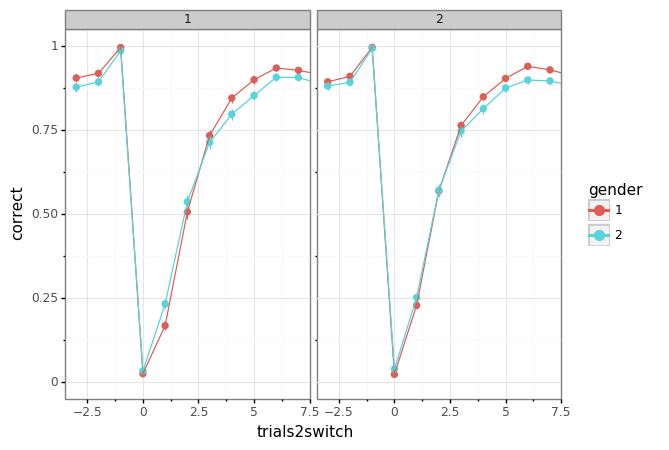

In [98]:
sub_dat = true_dat[true_dat.session < 10]
g = (gg.ggplot(true_dat, gg.aes('trials2switch', 'correct', color='gender'))
 + gg.stat_summary()
 + gg.stat_summary(geom='line')
 + gg.coord_cartesian(xlim=(-3, 7))
 + gg.facet_grid('~ agegroup')
)
g.draw()
g.save(os.path.join(plot_dir, 'mouse_trials2switch.png'))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\mouse_rew12back_switch.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


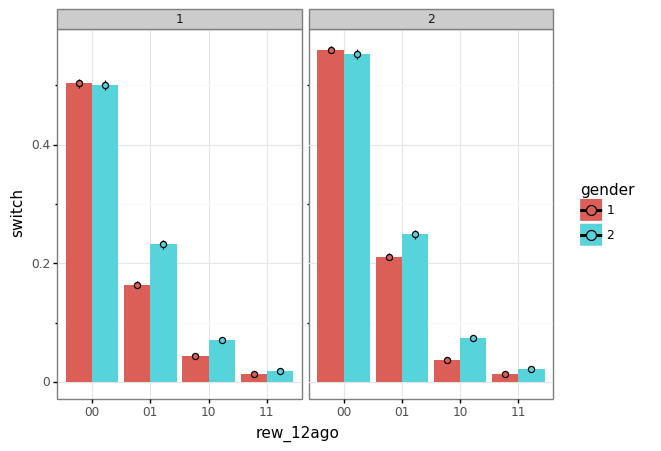

In [126]:
sub_dat = true_dat.loc[(true_dat.rew_12ago != '0n') * (true_dat.rew_12ago != '1n') * (true_dat.rew_12ago != 'nn')]

g = (gg.ggplot(sub_dat, gg.aes('rew_12ago', 'switch', fill='gender'))
     + gg.stat_summary(geom='bar', position=gg.position_dodge(width=0.9))
     + gg.stat_summary(position=gg.position_dodge(width=0.9))
     + gg.facet_grid('~ agegroup')
)
g.draw()
g.save(os.path.join(plot_dir, 'mouse_rew12back_switch.png'))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\mouse_rew12back.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


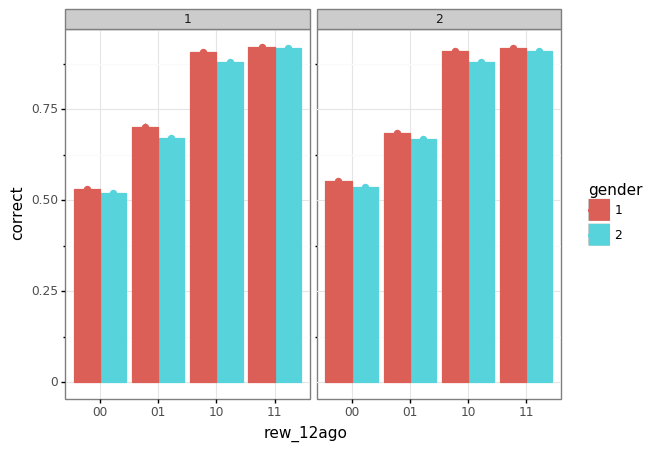

In [99]:
sub_dat = true_dat.loc[(true_dat.rew_12ago != '0n') * (true_dat.rew_12ago != '1n') * (true_dat.rew_12ago != 'nn')]

g = (gg.ggplot(sub_dat, gg.aes('rew_12ago', 'correct', fill='gender'))
     + gg.stat_summary(geom='bar', position=gg.position_dodge(width=0.9))
     + gg.stat_summary(position=gg.position_dodge(width=0.9))
     + gg.facet_grid('~ agegroup')
)
g.draw()
g.save(os.path.join(plot_dir, 'mouse_rew12back_correct.png'))

In [ ]:
g = (gg.ggplot(true_dat, gg.aes('block_trial', 'correct', color='gender'))
 + gg.stat_summary()
 + gg.facet_wrap('~ agegroup')
)
g.draw()
g.save(os.path.join(plot_dir, 'mouse_trial_correct.png'))

In [ ]:
g = (gg.ggplot(true_dat, gg.aes('block', 'correct', color='gender', group='gender'))
 + gg.stat_summary()
 + gg.facet_wrap('~ agegroup')
)
g.draw()
g.save(os.path.join(plot_dir, 'mouse_block_correct.png'))

In [ ]:
g = (gg.ggplot(true_dat, gg.aes('session', 'correct', color='gender'))
 + gg.stat_summary()
 + gg.facet_wrap('~ agegroup')
)
g.draw()
g.save(os.path.join(plot_dir, 'mouse_session_correct.png'))